<a href="https://colab.research.google.com/github/LukeAndrewSmith/DM_Project/blob/master/DM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Reading and Cleaning
=========================

## Helpers

In [0]:
# Pretty print helpers
def print_section(title):
    print()
    print('=' * (len(title) + 4))
    print(' ', title)
    print('=' * (len(title) + 4))

def print_subsection(title):
    print('-' * (len(title) + 4))
    print(' ', title)
    print('-' * (len(title) + 4))

# Array diff
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

Beijing
-------


### Importing the data
We will begin by importing the csv files into pandas dataframes, a data type that can greatly simplify the process of data cleansing.

We also print out the time taken to read the csv files.

Note that we converted the Beijing_AirQuality_Stations_en.xls file to a csv, removing the unnecessary info.


In [0]:
import pandas as pd
import numpy as np
from timeit import default_timer as timer

# Ensure pandas outputs all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

def get_dataframe(filename):
    df = pd.read_csv(filename)
    return df

if 'aq_1' in globals():
  del aq_1
if 'aq_2' in globals():
  del aq_2
if 'meo_1' in globals():
  del meo_1
if 'meo_2' in globals():
  del meo_2
if 'meo_3' in globals():
  del meo_3
if 'aq_stations' in globals():
  del aq_stations

start = timer()
aq_1 = get_dataframe('beijing_17_18_aq.csv')
aq_2 = get_dataframe('beijing_201802_201803_aq.csv')
meo_1 = get_dataframe('beijing_17_18_meo.csv')
meo_2 = get_dataframe('beijing_201802_201803_me.csv')
meo_3 = get_dataframe('Beijing_historical_meo_grid.csv')
aq_stations = get_dataframe('Beijing_AirQuality_Stations_en.csv')
end = timer()

print_section('Time')
print(end - start)



  Time
0.7360401200003253


### Initial look at the data
We will print the heads of the **DataFrames** to get an idea of the information each csv can provided.\
We will also find the max/min times to check that the date ranges between the AQ and MEO data correspond.

In [0]:
## AQ
print_section('beijing_17_18_aq.csv')
print_subsection('head')
print(aq_1.head(1))
print_subsection('utc_time')
print('Min:', aq_1.utc_time.min())
print('Max:', aq_1.utc_time.max())

print_section('beijing_201802_201803_aq.csv')
print_subsection('head')
print(aq_2.head(1))
print_subsection('utc_time')
print('Min:', aq_2.utc_time.min())
print('Max:', aq_2.utc_time.max())

## MEO
print_section('beijing_17_18_meo.csv')
print_subsection('head')
print(meo_1.head(1))
print_subsection('utc_time')
print('Min:', meo_1.utc_time.min())
print('Max:', meo_1.utc_time.max())

print_section('beijing_201802_201803_me.csv')
print_subsection('head')
print(meo_2.head(1))
print_subsection('utc_time')
print('Min:', meo_2.utc_time.min())
print('Max:', meo_2.utc_time.max())

print_section('Beijing_historical_meo_grid.csv')
print_subsection('head')
print(meo_3.head(1))

# Check that the features of meo_1 and meo_2 correspond
print_section('Diff meo_1 meo_2')
print_subsection('Features')
print(diff(meo_1.columns, meo_2.columns))
print(diff(meo_2.columns, meo_1.columns))


  beijing_17_18_aq.csv
--------
  head
--------
         stationId             utc_time  PM2.5   PM10    NO2   CO   O3  SO2
0  aotizhongxin_aq  2017-01-01 14:00:00  453.0  467.0  156.0  7.2  3.0  9.0
------------
  utc_time
------------
Min: 2017-01-01 14:00:00
Max: 2018-01-31 15:00:00

  beijing_201802_201803_aq.csv
--------
  head
--------
         stationId             utc_time  PM2.5  PM10   NO2   CO   O3   SO2
0  aotizhongxin_aq  2018-01-31 16:00:00   49.0  82.0  90.0  0.9  6.0  10.0
------------
  utc_time
------------
Min: 2018-01-31 16:00:00
Max: 2018-03-31 15:00:00

  beijing_17_18_meo.csv
--------
  head
--------
   station_id   longitude   latitude             utc_time  temperature  pressure  humidity  wind_direction  wind_speed      weather
0  shunyi_meo  116.615278  40.126667  2017-01-30 16:00:00         -1.7    1028.7        15           215.0         1.6  Sunny/clear
------------
  utc_time
------------
Min: 2017-01-30 16:00:00
Max: 2018-01-31 15:00:00

  beijing_201802

### Observations
Above we can see that the files
beijing_17_18_aq.csv and beijing_201802_201803_aq.csv
contain all the necessary info for the air quality and the files 
beijing_17_18_meo.csv and beijing_201802_201803_me.csv
contain all the necessary info for the meteorological data.

The file Beijing_historical_meo_grid.csv contains grid data for a smaller time period and does not correspond directly with the AQ data. \
**Decision** \
We could use the Data to help interpolate the missing values in the MEO datasets but we will not as we don't have the time.

We can also see that 
beijing_17_18_meo.csv
begins on 2017-01-30 rather than 2017-01-01 like for the AQ data sets, and so we will need to drop the first 30 days from the AQ data sets or add nans and interpolate.
**Decision** \
We will add nans and interpolate.

### Cleaning and merging the data

####Get all utc_times

In [0]:
# Each station should have the following datetimes
# times = [2017-01-01 00:00:00, ... , 2018-03-20 23:00:00]

from datetime import timedelta, date, datetime

def daterange(date1, date2):
    for m in range(int ((date2 - date1).days)+1):
        for n in range(24):
            yield date1 + timedelta(days=m,hours=n)

start_dt = datetime(2016, 12, 31, 23, 0, 0)
end_dt = datetime(2018, 3, 20, 23, 0, 0)
ran = daterange(start_dt, end_dt)
times = [r.strftime("%Y-%m-%d %H:%M:%S") for r in ran]
print(times[1:10])
print(times[-1])

['2017-01-01 00:00:00', '2017-01-01 01:00:00', '2017-01-01 02:00:00', '2017-01-01 03:00:00', '2017-01-01 04:00:00', '2017-01-01 05:00:00', '2017-01-01 06:00:00', '2017-01-01 07:00:00', '2017-01-01 08:00:00']
2018-03-21 22:00:00


####AQ fill in missing utc_time + interpolate + plot


  Missing AQ
----------------------
  Rows to add format
----------------------
[{'utc_time': '2017-01-01 00:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 01:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 02:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 03:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 04:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 05:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 06:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 07:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 08:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 09:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 10:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 11:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01-01 12:00:00', 'stationId': 'aotizhongxin_aq'}, {'utc_time': '2017-01

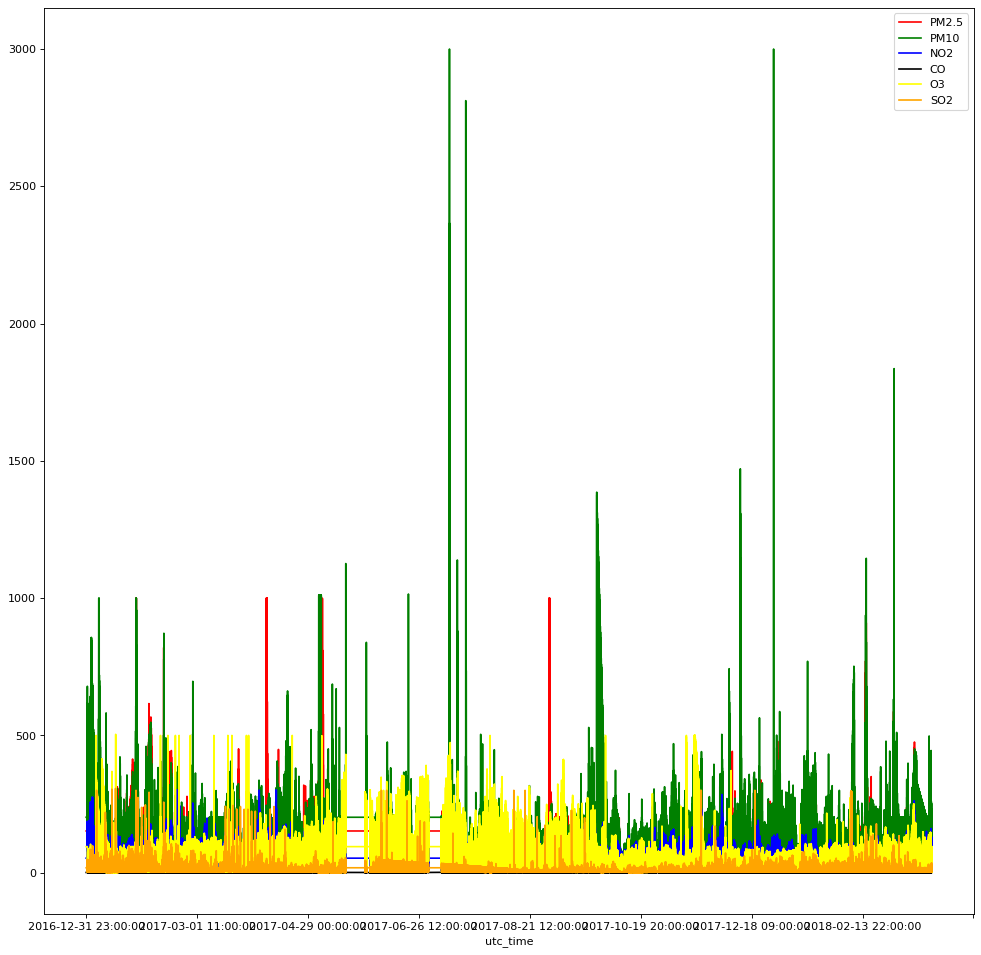

In [0]:
# AQ Merge Tables

# Concat
aq = aq_1.append(aq_2)

#### DECISION ####
# Not all the required hours/days (utc_time's) are presents
# We will add NaNs for missing utc_time's and they will be filled in with the interpolation below
print_section('Missing AQ')
missing_aq = []
for id in aq.stationId.unique():
    dates_id = aq[aq.stationId == id].utc_time
    missing_dates_id = diff(times, dates_id)
    for date in missing_dates_id:
        missing_aq.append({'utc_time': date, 'stationId': id})

print_subsection('Rows to add format')
print(missing_aq[1:20])

print_subsection('Shapes before/after add')
print(aq.shape[0])
aq = aq.append(missing_aq, ignore_index=True)
print(aq.shape[0])

print_subsection('Verify all dates')
print('Check diff between expected times and actual for each station, should be an array of zeros')
len_check = []
for id in aq.stationId.unique():
    len_check.append(len(diff(times, aq[aq.stationId == id]['utc_time'].unique())))
print(len_check)

#### DECISION ####
# Interpolate before separating the test/train data, IS THIS WRONG?????
# TODO: Interpolate the stations separately????????????????????????
# Interpolate missing values
aq.interpolate(method='linear', inplace=True)

# Keep only up till 2018-03-22
aq = aq[aq.utc_time < '2018-03-23']
# Make sure stations are sorted alphabetically
aq = aq.sort_values(['utc_time', 'stationId'])

# Plots
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')

ax = plt.gca()
aq.plot(kind='line',x='utc_time',y='PM2.5', color='red', ax=ax)
aq.plot(kind='line',x='utc_time',y='PM10', color='green', ax=ax)
aq.plot(kind='line',x='utc_time',y='NO2', color='blue', ax=ax)
aq.plot(kind='line',x='utc_time',y='CO', color='black', ax=ax)
aq.plot(kind='line',x='utc_time',y='O3', color='yellow', ax=ax)
aq.plot(kind='line',x='utc_time',y='SO2', color='orange', ax=ax)
plt.show()

####MEO fill in missing utc_time + interpolate + plot


  Missing MEO
----------------------
  Rows to add format
----------------------
[{'utc_time': '2017-01-01 00:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 01:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 02:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 03:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 04:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 05:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 06:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 07:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 08:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 09:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 10:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 11:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 12:00:00', 'station_id': 'shunyi_meo'}, {'utc_time': '2017-01-01 13:00:00', 'station_id': 'shunyi_meo'}, {'utc_t

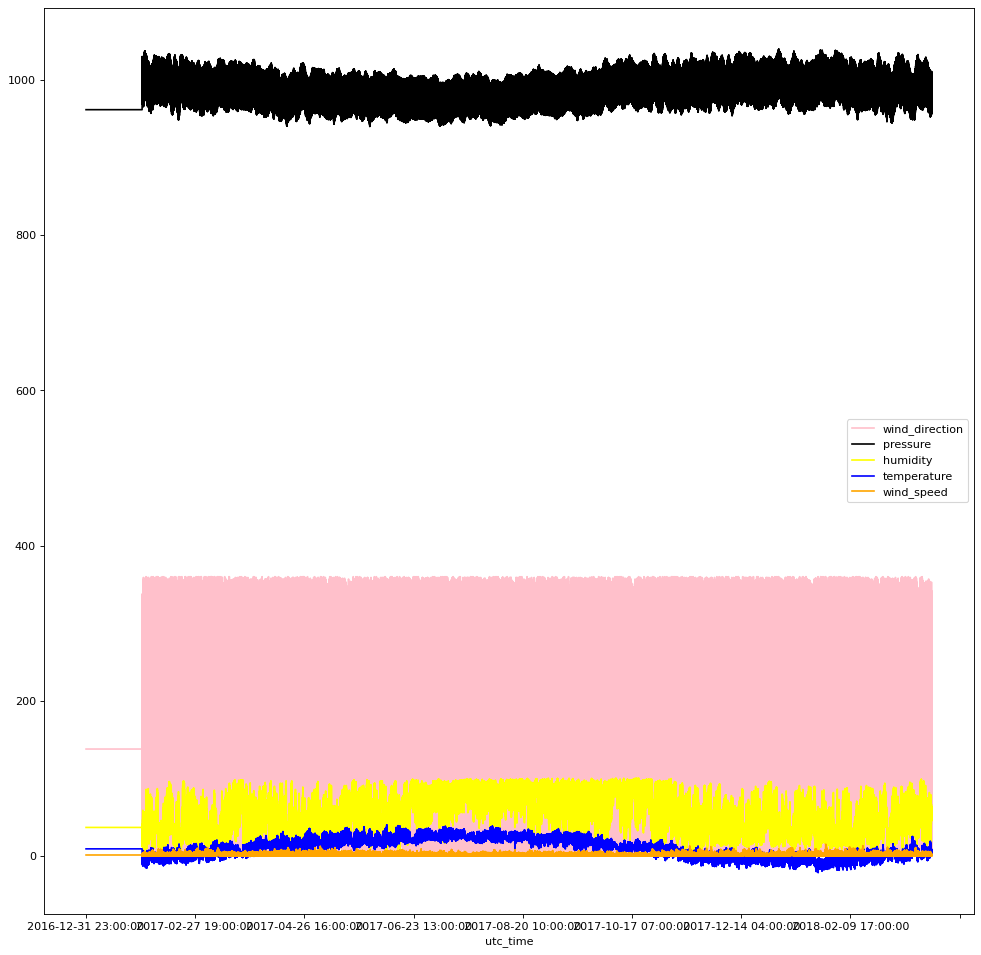

In [0]:
#MEO MERGE

#### DECISION ####
# Replace invalid wind_direction's by nan
meo_1 = meo_1.replace(meo_1[meo_1.wind_direction > 360]['wind_direction'].unique(), np.nan)
meo_2 = meo_2.replace(meo_2[meo_2.wind_direction > 360]['wind_direction'].unique(), np.nan)

#### DECISION ####
# Replace invalid humidities's by nan
meo_1 = meo_1.replace(meo_1[meo_1.humidity > 100]['humidity'].unique(), np.nan)
meo_2 = meo_2.replace(meo_2[meo_2.humidity > 100]['humidity'].unique(), np.nan)

#### DECISION ####
# TODO: Maybe get data from grid before interpolating (need long/lat)
# Decision: Don't take data from grid, don't have time 

# Drop lat/long, would be used if we fetched data from the grid before interpolating
if 'latitude' in meo_1:
    meo_1 = meo_1.drop(['latitude', 'longitude'], axis=1) # Drop unused columns

# Concat
meo = meo_1.append(meo_2)

#### DECISION ####
# Not all the required hours/days (utc_time's) are presents
# We will add NaNs for missing utc_time's and they will be filled in with the interpolation below
print_section('Missing MEO')
missing_meo = []
for id in meo.station_id.unique():
    dates_id = meo[meo.station_id == id].utc_time
    missing_dates_id = diff(times, dates_id)
    for date in missing_dates_id:
        missing_meo.append({'utc_time': date, 'station_id': id})

print_subsection('Rows to add format')
print(missing_meo[1:20])

print_subsection('Shapes before/after add')
print_subsection
print(meo.shape[0])
meo = meo.append(missing_meo, ignore_index=True)
print(meo.shape[0])

print_subsection('Verify all dates')
print('Check diff between expected times and actual for each station, should be an array of zeros')
len_check = []
for id in meo.station_id.unique():
    len_check.append(len(diff(times, meo[meo.station_id == id]['utc_time'].unique())))
print(len_check)


#### DECISION ####
# Interpolate before separating the test/train data, IS THIS WRONG?????
# TODO: Interpolate the stations separately????????????????????????
# Interpolate missing values
meo.interpolate(method='linear', inplace=True)

# Keep only up till 2018-03-22
meo = meo[meo.utc_time < '2018-03-23']
# Make sure stations are sorted alphabetically
meo = meo.sort_values(['utc_time', 'station_id'])


# Plots
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15, 15), dpi= 80, facecolor='w', edgecolor='k')

ax = plt.gca()
meo.plot(kind='line',x='utc_time',y='wind_direction', color='pink', ax=ax)
meo.plot(kind='line',x='utc_time',y='pressure', color='black', ax=ax)
meo.plot(kind='line',x='utc_time',y='humidity', color='yellow', ax=ax)
meo.plot(kind='line',x='utc_time',y='temperature', color='blue', ax=ax)
meo.plot(kind='line',x='utc_time',y='wind_speed', color='orange', ax=ax)
plt.show()

####AQ Concat 

In [0]:
if not aq.index.name == 'utc_time':
    aq = aq.set_index(['utc_time'])

# Add all info for a given utc_time to one column
aq_concat = aq[aq.stationId == aq.stationId.unique()[0]]
stations = aq.stationId.unique()[1:]
for station in stations:
    aq_concat = pd.concat([aq_concat,aq[aq.stationId == station]], axis=1)
#### DECISION ####
# Remove duplicate utc_time's
# Keep values from the first index instance
aq_concat = aq_concat.loc[~aq_concat.index.duplicated(keep='first')] 
print(aq_concat.index.is_unique)
# print(aq_concat)

True


####Create data

In [0]:
def history(h,df):
    dfHis = df.copy()
    utc_times = df.index.values

    for i in range(1,h+1):
        shifted = np.roll(utc_times, -i)
        toConcat = df.copy().reset_index()
        toConcat.utc_time = shifted
        toConcat = toConcat.set_index('utc_time')
        dfHis = pd.concat([dfHis,toConcat], axis=1)

    dfHis.drop(dfHis.index[:h], inplace=True)
    dfHis.drop(dfHis.index[-h:], inplace=True)
    return dfHis

df1 = pd.DataFrame([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]], columns=['utc_time','B']).set_index('utc_time')
print(df1)
print(history(3,df1))

print(aq_concat)
print(history(3,aq_concat))


           B
utc_time    
1          1
2          2
3          3
4          4
5          5
6          6
7          7
8          8
9          9
10        10
          B  B  B  B
utc_time            
4         4  3  2  1
5         5  4  3  2
6         6  5  4  3
7         7  6  5  4
                           stationId  PM2.5   PM10    NO2   CO    O3   SO2    stationId  PM2.5   PM10   NO2   CO    O3   SO2      stationId  PM2.5   PM10   NO2   CO    O3   SO2  stationId  PM2.5  \
utc_time                                                                                                                                                                                             
2016-12-31 23:00:00  aotizhongxin_aq  152.0  202.0   53.0  1.0  95.0  18.0  badaling_aq  152.0  202.0  53.0  1.0  95.0  18.0  beibuxinqu_aq  152.0  202.0  53.0  1.0  95.0  18.0  daxing_aq  152.0   
2017-01-01 00:00:00  aotizhongxin_aq  152.0  202.0   53.0  1.0  95.0  18.0  badaling_aq  152.0  202.0  53.0  1.0  95.0  18.0

In [0]:
print(aq)


# min_date = aq.index.min()[0:10]
# print(min_date)
# min_viable_date = min_date[0:8]+str(0)+str(int(min_date[9:10])+2) # TODO: only add 0 to left if date not double digit
# print(min_viable_date)
# max_date = aq.index.max()[0:10]
# print(max_date)


                stationId             utc_time  PM2.5   PM10    NO2   CO    O3   SO2
360430    aotizhongxin_aq  2017-01-01 00:00:00  152.0  202.0   53.0  1.0  95.0  18.0
361229        badaling_aq  2017-01-01 00:00:00  152.0  202.0   53.0  1.0  95.0  18.0
362028      beibuxinqu_aq  2017-01-01 00:00:00  152.0  202.0   53.0  1.0  95.0  18.0
362827          daxing_aq  2017-01-01 00:00:00  152.0  202.0   53.0  1.0  95.0  18.0
363626        dingling_aq  2017-01-01 00:00:00  152.0  202.0   53.0  1.0  95.0  18.0
...                   ...                  ...    ...    ...    ...  ...   ...   ...
357245  yongdingmennei_aq  2018-03-22 23:00:00  164.0  168.0  103.0  1.9   2.0  11.0
357989      yongledian_aq  2018-03-22 23:00:00  161.0  199.0  100.0  2.3   3.0   7.0
358733            yufa_aq  2018-03-22 23:00:00  156.0  186.0   81.0  1.2   2.0   6.0
359477         yungang_aq  2018-03-22 23:00:00  129.0  166.0  100.0  1.4   3.0   7.0
360221       zhiwuyuan_aq  2018-03-22 23:00:00  152.0  202.0   53

In [0]:
# RANDOM LINEAR REGRESSION ATTEMPT
from sklearn.model_selection import train_test_split


# import the relevant module for back...
import statsmodels.api as sm

# separate our my predictor variables (X) from my outcome variable y
X = df2[predictors]
y = df2['meantempm']

# # Add a constant to the predictor variable set to represent the Bo intercept
# X = sm.add_constant(X)
# X.ix[:5, :5]




# first remove the const column because unlike statsmodels, SciKit-Learn will add that in for us
X = X.drop('const', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)



from sklearn.linear_model import LinearRegression

# instantiate the regressor class
regressor = LinearRegression()

# fit the build the model by fitting the regressor to the training data
regressor.fit(X_train, y_train)

# make a prediction set using the test set
prediction = regressor.predict(X_test)

# Evaluate the prediction accuracy of the model
from sklearn.metrics import mean_absolute_error, median_absolute_error
print("The Explained Variance: %.2f" % regressor.score(X_test, y_test))
print("The Mean Absolute Error: %.2f degrees celsius" % mean_absolute_error(y_test, prediction))
print("The Median Absolute Error: %.2f degrees celsius" % median_absolute_error(y_test, prediction))

### Dummy Classifier


We'll be using https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html

In [0]:
from sklearn.dummy import DummyRegressor
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X, y)
dummy_regr.predict(X)
dummy_regr.score(X, y)